In [1]:
!source .env/bin/activate

# Importing libraries and modules

In [2]:
import os
import csv
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence
from torch.nn.functional import one_hot as one_hot_encoding

from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Models
from transformers import (BertForSequenceClassification,
                          BertModel,
                          BertConfig,
                          BertTokenizer, 
                          BertTokenizerFast, 
                          AutoTokenizer, 
                          AutoModelForSequenceClassification,
                          AutoConfig)

# Train
import evaluate
from datasets import Dataset
from transformers import TrainingArguments, Trainer

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-29 19:55:24.271455: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Helper functions

In [3]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [4]:
def get_device():
    """Returns the available device for computation.
    Returns:
        torch.device: available device for computation
    """
    compute_device = None
    if torch.cuda.is_available():
        compute_device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        compute_device = torch.device('mps')
    else:
        compute_device = torch.device('cpu')
    
    print(f'device is {compute_device}')
    return compute_device


def save_predictions_to_csv(predictions, file_path):
    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerows(predictions.items())
        

def save_to_csv(numpy_array: np.ndarray, filename: str):
    np.savetxt(filename, numpy_array, delimiter=",", fmt='%1d')
    
    
def tokenize_function(data, features='review'):
    return tokenizer(data[features], padding="max_length", truncation=True)


def perform_validation(loss_func, val_dataloader):
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:              
            X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)} # "token_type_ids":batch['token_type_ids'].to(device)
            y = batch["label"].to(device)   
                
            outputs = model(**X)
            loss = loss_fun(outputs.logits, y)
            val_loss += loss.item()
    return val_loss


def get_conf_matrix(dataloader, num_classes):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)} # "token_type_ids":batch['token_type_ids'].to(device)
            y = batch["label"].to(device)

            outputs = model(**X)
            y_pred = torch.argmax(outputs.logits, dim=-1)

            for t, p in zip(y.view(-1), y_pred.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

def class_accuracy(dataloader, num_classes):
    conf_matrix = get_conf_matrix(dataloader, num_classes)
    return conf_matrix.diag() / conf_matrix.sum(1)

# Params and constants

In [5]:
random_seed = 120
device = get_device()
# device = torch.device('cpu')

VAL_SET_FRACTION = 0.10

# class_names = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

train_data_path = 'p6/train_data.csv'
test_data_path = 'p6/test_data.csv'

device is cuda


In [6]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Loading data

In [7]:
train_data = pd.read_csv(train_data_path)
train_data.head()

,review,rating
0,location not palace excellent hotel booke dthe...,4
1,respite definitely not place stay looking ultr...,3
2,stunning truly memorable spot right beach nusa...,4
3,solid business hotel near embassy stayed hotel...,3
4,nice place make sure lock money warning money ...,3


In [8]:
train_data.shape

(16392, 2)

# EDA

### Num classes

In [9]:
num_classes = train_data['rating'].nunique()
num_classes

5

### Missing values

In [10]:
train_data.isna().sum()

review    0
rating    0
dtype: int64

### Sample values distribution

In [11]:
label_counts = Counter(train_data['rating'])
label_counts

Counter({4: 7243, 3: 4831, 2: 1747, 1: 1434, 0: 1137})

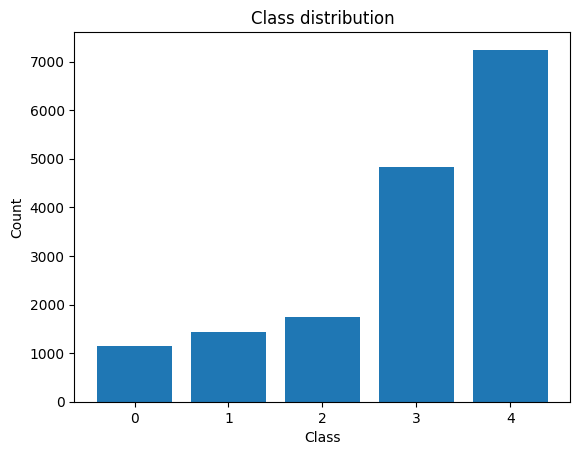

In [12]:
plt.bar(label_counts.keys(), label_counts.values())

plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()

We can observe a significant class imbalance in the dataset. This class imbalance will be evaluated later.

### Review length (num characters)

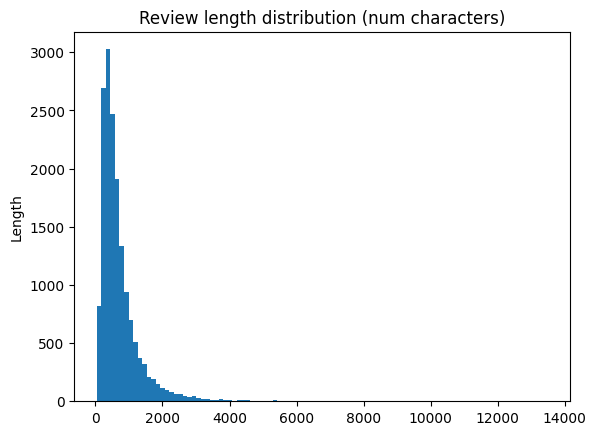

In [41]:
plt.hist(list(map(lambda x: len(x), train_data['review'])), bins=100)

plt.title('Review length distribution (num characters)')
plt.ylabel('Length')

plt.show()

### Average review length (num characters)

In [42]:
avg_num_characters_review = int(train_data['review'].apply(len).mean())
avg_num_characters_review

721

### Average review length per class (num characters)

In [43]:
num_characters_review_by_class = pd.concat([train_data['review'].apply(len), train_data['rating']], axis=1).apply(np.floor)
num_characters_review_by_class_grouped = num_characters_review_by_class.groupby('rating').mean()
num_characters_review_by_class_grouped

,review
rating,
0.0,752.415128
1.0,867.323570
2.0,789.626216
3.0,740.771683
4.0,657.967279


In [44]:
num_characters_review_by_class['review'].describe()

count    16392.000000
mean       721.268912
std        676.406258
min         44.000000
25%        339.000000
50%        535.000000
75%        857.000000
max      13501.000000
Name: review, dtype: float64

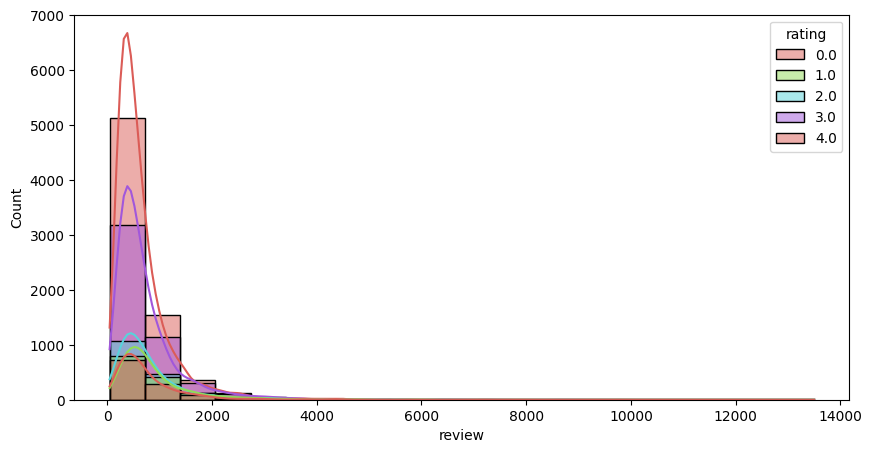

In [45]:
plt.figure(figsize=(10,5))
sns.histplot(x='review', data=num_characters_review_by_class, kde=True, hue='rating', bins=20, palette="hls")
plt.show()

Better rewievs in general have less characters

### Review length (num words)

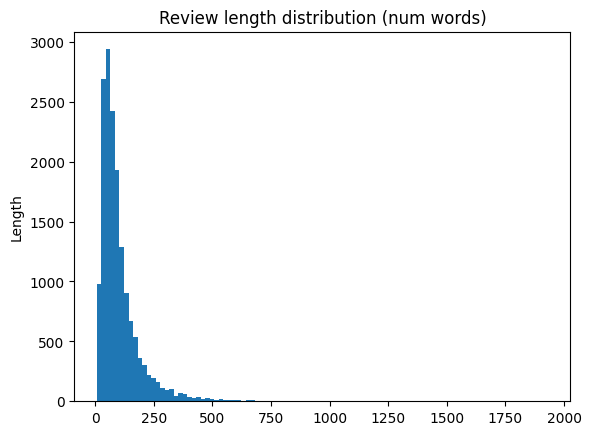

In [46]:
plt.hist(list(map(lambda x: len(x.split()), train_data['review'])), bins=100)

plt.title('Review length distribution (num words)')
plt.ylabel('Length')

plt.show()

### Average review length (num words)

In [47]:
avg_num_words_review = int(train_data['review'].apply(lambda x: len(x.split())).mean())
avg_num_words_review

103

### Average review length per class (num words)

In [48]:
num_words_review_by_class = pd.concat([train_data['review'].apply(lambda x: len(x.split())), train_data['rating']], axis=1).apply(np.floor)
num_words_review_by_class_grouped = num_words_review_by_class.groupby('rating').mean()
num_words_review_by_class_grouped

,review
rating,
0.0,109.764292
1.0,126.696653
2.0,115.452776
3.0,107.120265
4.0,93.429242


In [49]:
num_words_review_by_class['review'].describe()

count    16392.000000
mean       103.854746
std         98.886353
min          7.000000
25%         48.000000
50%         76.500000
75%        123.000000
max       1931.000000
Name: review, dtype: float64

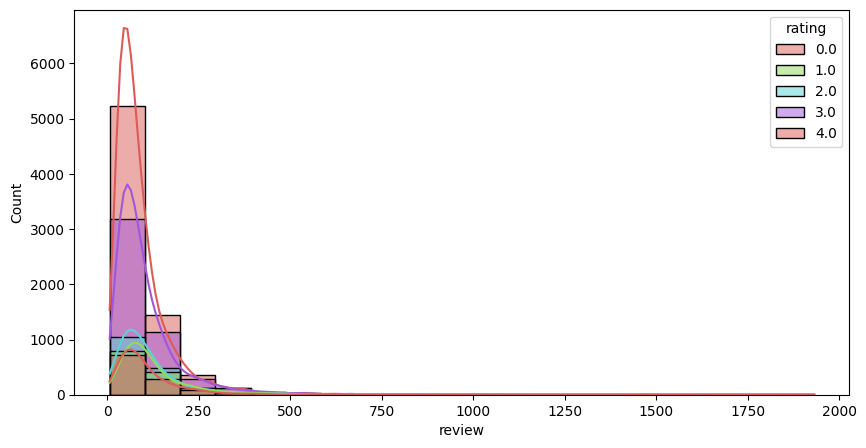

In [50]:
plt.figure(figsize=(10,5))
sns.histplot(x='review', data=num_words_review_by_class, kde=True, hue='rating', bins=20, palette="hls")
plt.show()

Better rewievs in general have less words

### Longest reviews

In [90]:
max(train_data['review'].apply(lambda x: len(x.split())))

1931

# Split data to train and validation sets

In [11]:
X, y = train_data['review'].values, train_data['rating'].values
X.shape, y.shape

((16392,), (16392,))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SET_FRACTION, stratify=y)
X_train.shape, X_val.shape

((14752,), (1640,))

# Preprocessing Pipeline

In [13]:
class LowerText:
  """Lowers text"""
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
     print('lower')
     return [value.lower() for value in X]


class FilterNewline:
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('newline')
    return [value.replace('\n', ' ').replace('\r', ' ') for value in X]


class FilterNumbers:
  def __init__(self):
    self.pattern = r'[0-9]+'

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('numbers')
    return [re.sub(self.pattern, '', value) for value in X]


class FilterASCII:
  def __init__(self):
    self.pattern = r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]'

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('ascii')
    return [re.sub(self.pattern, '', value).strip() for value in X]


class FilterPunctuations:
  def __init__(self):
    self.translator = str.maketrans('', '', string.punctuation)

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('punctuations')
    return [value.translate(self.translator) for value in X]


class Lemmatizer:
  def __init__(self):
    self.lemma_model = spacy.load('en_core_news_sm')
  
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('lemma')
    for i, value in enumerate(X):
      doc = self.lemma_model(value)
      X[i] = ' '.join([token.lemma_ for token in doc])
    return X


class Tokenizer_pipeline:
  def __init__(self, num_words, oov_token):
    self.num_words = num_words
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=self.num_words,
                              oov_token=self.oov_token)

  def fit(self, X, y=None):
    self.tokenizer.fit_on_texts(X)

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('tokenizer')
    return self.tokenizer.texts_to_sequences(X)


class Padding:
  def __init__(self, maxlen, padding='post', truncating='post'):
    self.maxlen = maxlen
    self.padding = padding
    self.truncating = truncating

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    return self.transform(X, y)

  def transform(self, X, y=None):
    print('padding')
    return pad_sequences(X, padding=self.padding, truncating=self.truncating, maxlen=self.maxlen)

In [14]:
pipeline = Pipeline(steps=[
    ('lower_text', LowerText()),
    ('filter_newline', FilterNewline()),
    ('filer_numbers', FilterNumbers()),
    ('filer_ascii', FilterASCII()),
    ('filter_punctuations', FilterPunctuations()),
    # ('lemmatizer', Lemmatizer()),
    # ('tokenizer', Tokenizer_pipeline(NUM_WORDS, OOV_TOKEN)),
    # ('padding', Padding(MAX_TWEET_LENGTH, padding='post', truncating='post'))
    ])

### Transforming the data

In [15]:
X_train_prepared = pipeline.fit_transform(X_train)

lower
newline
numbers
ascii
punctuations


In [16]:
X_val_prepared = pipeline.transform(X_val)

lower
newline
numbers
ascii
punctuations


In [17]:
y_train_prepared = y_train
y_val_prepared = y_val

# Datasets

In [18]:
train_dataset = Dataset.from_dict({'review': X_train_prepared, 'label': y_train_prepared})
train_dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 14752
})

In [19]:
val_dataset = Dataset.from_dict({'review': X_val_prepared, 'label': y_val_prepared})
val_dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 1640
})

# Models

## - Pretrained BERT

In [20]:
model_name = "bert-base-uncased"
 
configuration = AutoConfig.from_pretrained(model_name)
configuration.hidden_dropout_prob = 0.5
configuration.attention_probs_dropout_prob = 0.5
configuration.classifier_dropout = 0.5
configuration.num_labels = num_classes
configuration.problem_type = "multi_label_classification"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, problem_type="multi_label_classification")
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Tokenizer

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [22]:
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
train_dataset_tokenized = train_dataset_tokenized.remove_columns(['review'])
train_dataset_tokenized.set_format("torch")

val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True)
val_dataset_tokenized = val_dataset_tokenized.remove_columns(['review'])
val_dataset_tokenized.set_format("torch")

100%|██████████| 2/2 [00:00<00:00,  5.77ba/s]


### Dataloaders

In [23]:
train_dataloader = DataLoader(train_dataset_tokenized, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset_tokenized, batch_size=32)

### Train

In [24]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_prepared), y=y_train_prepared.flatten())

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.8841, 2.2854, 1.8768, 0.6786, 0.4527], device='cuda:0')

In [25]:
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fun = nn.CrossEntropyLoss()  # weight=class_weights

In [27]:
num_epochs = 4
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_epoch_loss = 0
    for batch in tqdm(train_dataloader):
        X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
        y = batch["label"].to(device)
        
        outputs = model(**X)
        loss = loss_fun(outputs.logits, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        train_epoch_loss += loss.item()
    
    avg_epoch_loss = train_epoch_loss / len(train_dataloader)
    train_loss_history.append(avg_epoch_loss)
    
    val_loss = perform_validation(loss_fun, val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)
    
    print(f'Epoch {epoch}: Train Loss: {avg_epoch_loss}')
    print(f'Val Loss: {avg_val_loss}')
    
    print('Saving model')
    torch.save(model.state_dict(), f"models/bert_torch_{epoch}.pt")

100%|██████████| 461/461 [06:42<00:00,  1.15it/s]


Epoch 0: Train Loss: 0.9130489360743127
Val Loss: 0.7407516607871423
Saving model


100%|██████████| 461/461 [07:16<00:00,  1.06it/s]


Epoch 1: Train Loss: 0.6710048010188949
Val Loss: 0.7301751902470222
Saving model


100%|██████████| 461/461 [07:51<00:00,  1.02s/it]


Epoch 2: Train Loss: 0.4997096425993065
Val Loss: 0.8183376021110095
Saving model


100%|██████████| 461/461 [10:40<00:00,  1.39s/it]


Epoch 3: Train Loss: 0.28914906553229125
Val Loss: 0.9477636011747214
Saving model


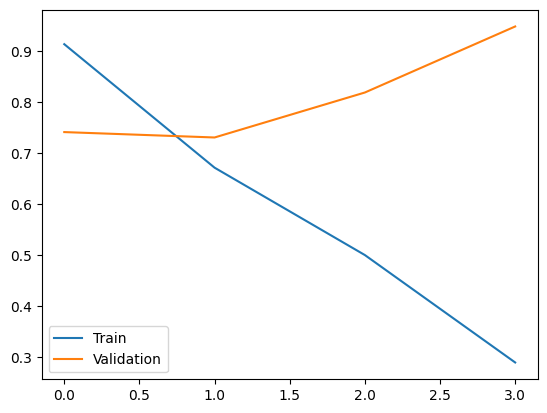

In [28]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.legend()

plt.show()

### Evaluate

In [33]:
model.load_state_dict(torch.load('models/bert_torch_1.pt'))

<All keys matched successfully>

Val

In [34]:
metric = evaluate.load("accuracy")

model.eval()
for batch in val_dataloader:
    X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device), "token_type_ids":batch['token_type_ids'].to(device)}
    y = batch["label"].to(device)
    
    with torch.no_grad():
        outputs = model(**X)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=y)

metric.compute()

{'accuracy': 0.6713414634146342}

Train

In [151]:
metric = evaluate.load("accuracy")

model.eval()
for batch in tqdm(train_dataloader):
    X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
    y = batch["label"].to(device)
    
    with torch.no_grad():
        outputs = model(**X)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=y)

metric.compute()

{'accuracy': 0.8260574837310195}

### Class accuracy

In [37]:
train_acc_per_class = class_accuracy(train_dataloader, num_classes)
val_acc_per_class = class_accuracy(val_dataloader, num_classes)

print(f'Train class acc: {train_acc_per_class}')
print(f'Val class acc: {val_acc_per_class}')


100%|██████████| 52/52 [00:33<00:00,  1.55it/s]

Train class acc: tensor([0.9599, 0.6615, 0.6075, 0.6449, 0.9323])
Val class acc: tensor([0.8246, 0.4266, 0.4114, 0.5052, 0.8690])


In [38]:
print(f'Train acc: {torch.mean(train_acc_per_class)}')
print(f'Val acc: {torch.mean(val_acc_per_class)}')

Train acc: 0.7612332105636597
Val acc: 0.6073409914970398


## - Pretrained BERT Tiny 128

In [95]:
max_length = 512

In [96]:
model_name = "google/bert_uncased_L-2_H-128_A-2"
 
configuration = BertConfig.from_pretrained(model_name)
configuration.hidden_dropout_prob = 0.5
configuration.attention_probs_dropout_prob = 0.5
configuration.classifier_dropout = 0.5
configuration.max_length = max_length
# configuration.max_position_embeddings = max_length
configuration.num_labels = num_classes


model = BertForSequenceClassification.from_pretrained(model_name, config=configuration) #, num_labels=num_classes, problem_type="multi_label_classification"
model

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

### Tokenizer

In [97]:
tokenizer = BertTokenizer.from_pretrained(model_name, model_max_length=max_length)
tokenizer

PreTrainedTokenizer(name_or_path='google/bert_uncased_L-2_H-128_A-2', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [98]:
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
train_dataset_tokenized = train_dataset_tokenized.remove_columns(['review'])
train_dataset_tokenized.set_format("torch")

val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True)
val_dataset_tokenized = val_dataset_tokenized.remove_columns(['review'])
val_dataset_tokenized.set_format("torch")

100%|██████████| 2/2 [00:03<00:00,  1.58s/ba]


### Dataloaders

In [99]:
train_dataloader = DataLoader(train_dataset_tokenized, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset_tokenized, batch_size=32)

### Train

In [100]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_prepared), y=y_train_prepared.flatten())
class_weights = class_weights + np.array([0, 0, 0.5, 1, 0])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.8841, 2.2854, 2.3768, 1.6786, 0.4527], device='cuda:0')

In [101]:
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # , weight_decay=0.0001
loss_fun = nn.CrossEntropyLoss() # weight=class_weights

In [102]:
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_epoch_loss = 0
    for batch in tqdm(train_dataloader):
        X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device), "token_type_ids":batch['token_type_ids'].to(device)}
        y = batch["label"].to(device)
        
        outputs = model(**X)
        loss = loss_fun(outputs.logits, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        train_epoch_loss += loss.item()
    
    avg_epoch_loss = train_epoch_loss / len(train_dataloader)
    train_loss_history.append(avg_epoch_loss)
    
    val_loss = perform_validation(loss_fun, val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)
    
    print(f'Epoch {epoch}: Train Loss: {avg_epoch_loss}')
    print(f'Val Loss: {avg_val_loss}')

100%|██████████| 461/461 [00:12<00:00, 38.11it/s]


Epoch 0: Train Loss: 1.5094026040099966
Val Loss: 1.4451541602611542
Saving model


100%|██████████| 461/461 [00:11<00:00, 39.61it/s]


Epoch 1: Train Loss: 1.319034613264874
Val Loss: 1.2283558272398436
Saving model


100%|██████████| 461/461 [00:12<00:00, 37.29it/s]


Epoch 2: Train Loss: 1.1396620779130568
Val Loss: 1.1121864846119514
Saving model


100%|██████████| 461/461 [00:11<00:00, 38.86it/s]


Epoch 3: Train Loss: 1.0393850340501865
Val Loss: 1.0519007295370102
Saving model


100%|██████████| 461/461 [00:12<00:00, 37.91it/s]


Epoch 4: Train Loss: 0.9678180495725537
Val Loss: 1.0143902829060187
Saving model


100%|██████████| 461/461 [00:11<00:00, 39.46it/s]


Epoch 5: Train Loss: 0.9132458183615431
Val Loss: 0.9803550736262248
Saving model


100%|██████████| 461/461 [00:12<00:00, 38.23it/s]


Epoch 6: Train Loss: 0.8690008492635284
Val Loss: 0.9723382878762025
Saving model


100%|██████████| 461/461 [00:11<00:00, 39.66it/s]


Epoch 7: Train Loss: 0.8287243618106636
Val Loss: 0.9600987331225321
Saving model


100%|██████████| 461/461 [00:12<00:00, 38.29it/s]


Epoch 8: Train Loss: 0.7914163681664332
Val Loss: 0.9568282377261382
Saving model


100%|██████████| 461/461 [00:11<00:00, 39.28it/s]


Epoch 9: Train Loss: 0.7549753833618702
Val Loss: 0.9704063592048792
Saving model


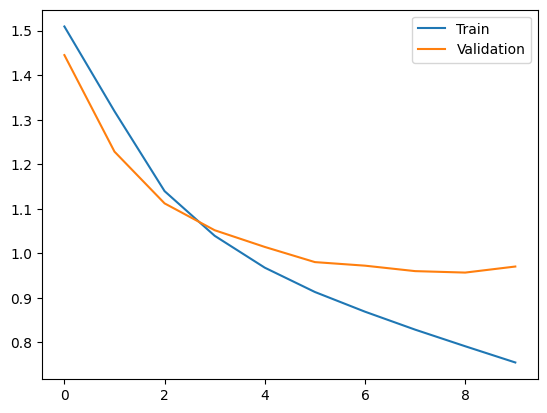

In [104]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.savefig('train_tiny_bert.png')

plt.show()


Evaluate

In [105]:
metric = evaluate.load("accuracy")

model.eval()
for batch in val_dataloader:
    X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device), "token_type_ids":batch['token_type_ids'].to(device)}
    y = batch["label"].to(device)
    
    with torch.no_grad():
        outputs = model(**X)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=y)

metric.compute()

{'accuracy': 0.5439024390243903}

## - Pretrained BERT HF Transformers

In [38]:
training_args = TrainingArguments(output_dir="train_checkpoint_dir",
                                  label_names=['label'],
                                  num_train_epochs=5,
                                  evaluation_strategy="epoch"
                                  )

Evaluation while training

In [39]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Trainer

In [1]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=val_dataset_tokenized,
    compute_metrics=compute_metrics,
)

trainer.train()

## - Pretrained XLM Roberta Base

In [43]:
model_name = "xlm-roberta-base"
 
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, problem_type="multi_label_classification") #, num_labels=num_classes, problem_type="multi_label_classification", config=configuration
model

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [45]:
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
train_dataset_tokenized = train_dataset_tokenized.remove_columns(['review'])
train_dataset_tokenized.set_format("torch")

val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True)
val_dataset_tokenized = val_dataset_tokenized.remove_columns(['review'])
val_dataset_tokenized.set_format("torch")

100%|██████████| 2/2 [00:00<00:00,  6.46ba/s]


### Dataloaders

In [46]:
train_dataloader = DataLoader(train_dataset_tokenized, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset_tokenized, batch_size=32)

### Train

In [47]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_prepared), y=y_train_prepared.flatten())
class_weights = class_weights + np.array([0, 0, 0, 0, 0])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.8841, 2.2854, 1.8768, 0.6786, 0.4527], device='cuda:0')

In [48]:
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fun = nn.CrossEntropyLoss(weight=class_weights)  # weight=class_weights

In [ ]:
num_epochs = 4
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    train_epoch_loss = 0
    for batch in tqdm(train_dataloader):
        X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}  # , "token_type_ids":batch['token_type_ids'].to(device)
        y = batch["label"].to(device)
        
        outputs = model(**X)
        loss = loss_fun(outputs.logits, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        train_epoch_loss += loss.item()
    
    avg_epoch_loss = train_epoch_loss / len(train_dataloader)
    train_loss_history.append(avg_epoch_loss)
    
    val_loss = perform_validation(loss_fun, val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)
    
    print(f'Epoch {epoch}: Train Loss: {avg_epoch_loss}')
    print(f'Val Loss: {avg_val_loss}')
    
    print('Saving model')
    torch.save(model.state_dict(), f"models/xlm_torch_weighted_{epoch}.pt")

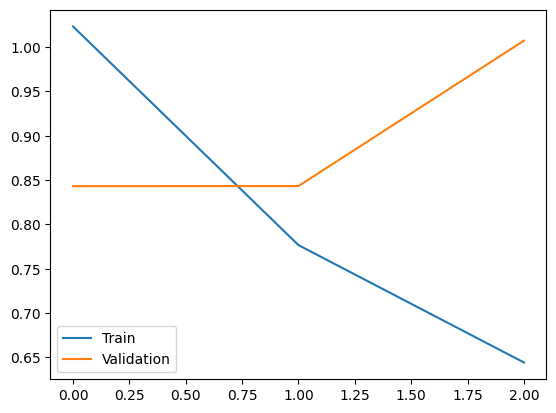

In [51]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.savefig('train.png')

plt.show()


### Evaluate

In [39]:
model.load_state_dict(torch.load('models/xlm_torch_1.pt'))

<All keys matched successfully>

In [54]:
metric = evaluate.load("accuracy")

model.eval()
for batch in tqdm(val_dataloader):
    X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
    y = batch["label"].to(device)
    
    with torch.no_grad():
        outputs = model(**X)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=y)

metric.compute()

100%|██████████| 52/52 [00:23<00:00,  2.26it/s]


{'accuracy': 0.6719512195121952}

### Class accuracy

In [52]:
train_acc_per_class = class_accuracy(train_dataloader, num_classes)
val_acc_per_class = class_accuracy(val_dataloader, num_classes)

print(f'Train class acc: {train_acc_per_class}')
print(f'Val class acc: {val_acc_per_class}')


100%|██████████| 52/52 [00:22<00:00,  2.31it/s]

Val class acc: tensor([0.5088, 0.5944, 0.5943, 0.5010, 0.8455])


In [53]:
print(f'Train acc: {torch.mean(train_acc_per_class)}')
print(f'Val acc: {torch.mean(val_acc_per_class)}')

Val acc: 0.6088031530380249


# Testing

### Load test data

In [39]:
test_data = pd.read_csv(test_data_path, header=None)
test_data.columns = ['review']
test_data.head()

,review
0,great hotel location stayed 4 nts 24th 28th ja...
1,"n't return overall disappointed hotel, no hot ..."
2,great value location desired problem hotel loc...
3,kind helpfull people people kind helpful.we no...
4,absolutely fabulous melia comfortable star hot...


In [40]:
test_data.shape

(4099, 1)

In [41]:
X_test = test_data['review'].values

### Preprocess test data using pipeline

In [42]:
X_test_prepared = pipeline.transform(X_test)

lower
newline
numbers
ascii
punctuations


### Dataset

In [43]:
test_dataset = Dataset.from_dict({'review': X_test_prepared})
test_dataset

Dataset({
    features: ['review'],
    num_rows: 4099
})

### Tokenize

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [45]:
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)
# test_dataset_tokenized = test_dataset.remove_columns(['review'])
test_dataset_tokenized.set_format("torch")

100%|██████████| 5/5 [00:00<00:00,  5.29ba/s]


In [46]:
test_dataset_tokenized

Dataset({
    features: ['review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4099
})

### Dataloader

In [47]:
test_dataloader = DataLoader(test_dataset_tokenized, batch_size=32)

### Predict

In [48]:
def predict_for_test_dataset(test_dataloader, model):
    with torch.no_grad():
        predictions = []
        for batch in tqdm(test_dataloader):
            X = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
            
            outputs = model(**X)
            y_pred = torch.argmax(outputs.logits, dim=-1)
            predictions.append(y_pred)
        predictions_flat = [prediction.item() for sublist in predictions for prediction in sublist]
    return predictions_flat

In [49]:
predictions = predict_for_test_dataset(test_dataloader, model)
np.array(predictions).shape

100%|██████████| 129/129 [01:17<00:00,  1.67it/s]


(4099,)

In [50]:
save_to_csv(predictions, f'{model_name}.csv')